## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

## Read dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/Span_Level/DRCN_DS_2/DS_SpanLev_1e4_25100_64_50120.csv")
data.head()

,Lspan(km),Power(dBm),CUT-Num,CUT-DEV,Total-LSP(%),RH-LSP(%),RH-Idle,LH-LSP(%),LH-Idle,Power-NLI(dB),Power-ASE(dB),GSNR-Span(dB)
0,60,-3.0,25,5,59.322,61.765,0,54.167,1,-75.448,-61.875,28.688
1,95,-5.0,17,13,93.220,92.857,0,93.750,0,-79.850,-53.997,18.986
2,110,-2.5,7,23,64.407,65.385,1,50.000,2,-74.588,-50.678,18.161
3,75,3.0,33,3,42.373,38.462,1,43.750,0,-57.463,-58.460,27.923
4,105,1.5,23,7,100.000,100.000,0,100.000,0,-60.074,-51.783,22.683


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rs(GBaud)      10000 non-null  int64  
 1   Lspan(km)      10000 non-null  int64  
 2   Power(dBm)     10000 non-null  float64
 3   CUT-Num        10000 non-null  int64  
 4   CUT-DEV        10000 non-null  int64  
 5   Total-LSP(%)   10000 non-null  float64
 6   RH-LSP(%)      10000 non-null  float64
 7   RH-Idle        10000 non-null  int64  
 8   LH-LSP(%)      10000 non-null  float64
 9   LH-Idle        10000 non-null  int64  
 10  Power-NLI(dB)  10000 non-null  float64
 11  Power-ASE(dB)  10000 non-null  float64
 12  GSNR-Span(dB)  10000 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1015.8 KB


In [ ]:
data.describe()

,Lspan(km),Power(dBm),CUT-Num,CUT-DEV,Total-LSP(%),RH-LSP(%),RH-Idle,LH-LSP(%),LH-Idle,Power-NLI(dB),Power-ASE(dB),GSNR-Span(dB)
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,85.030000,0.012250,29.849400,14.84580,63.131178,61.378871,0.775200,61.324314,0.757900,-66.347386,-56.258175,24.657598
std,21.674088,3.019642,17.112978,8.51216,21.645543,25.702371,1.462149,25.830491,1.480036,9.131206,4.862251,4.297786
min,50.000000,-5.000000,1.000000,0.00000,25.424000,0.000000,0.000000,0.000000,0.000000,-84.264000,-64.221000,13.468000
25%,65.000000,-2.500000,15.000000,8.00000,44.068000,41.667000,0.000000,41.860000,0.000000,-74.192000,-60.726000,21.577750
50%,85.000000,0.000000,30.000000,15.00000,62.712000,62.500000,0.000000,62.500000,0.000000,-66.400000,-56.221000,25.053000
75%,105.000000,2.500000,45.000000,22.00000,81.356000,83.333000,1.000000,83.333000,1.000000,-58.455500,-51.783000,27.982500
max,120.000000,5.000000,59.000000,29.00000,100.000000,100.000000,14.000000,100.000000,17.000000,-49.535000,-48.472000,33.052000


## Data Analysis

In [ ]:
col = data.columns       # .columns gives columns names in data 
print(col)

Index(['Rs(GBaud)', 'Lspan(km)', 'Power(dBm)', 'CUT-Num', 'CUT-DEV',
       'Total-LSP(%)', 'RH-LSP(%)', 'RH-Idle', 'LH-LSP(%)', 'LH-Idle',
       'Power-NLI(dB)', 'Power-ASE(dB)', 'GSNR-Span(dB)'],
      dtype='object')


## Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a0986c690>,
      dtype=object)

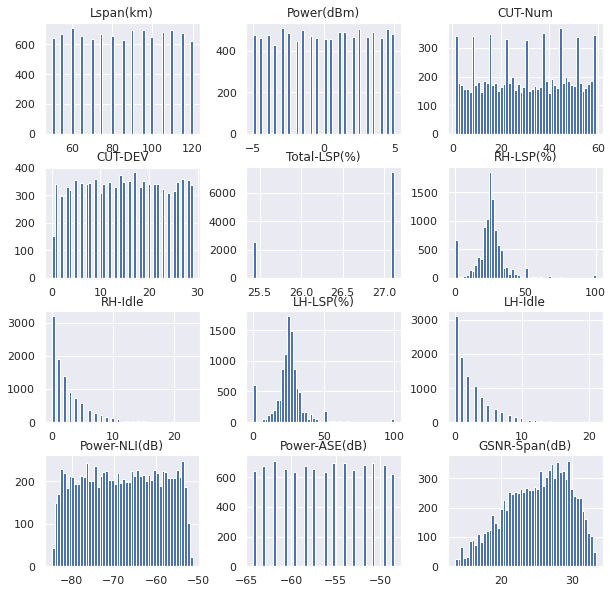

In [ ]:
data.hist(bins=50, figsize=(10,10)) # to plot histogram of all columns in the dataset

<Figure size 432x288 with 0 Axes>

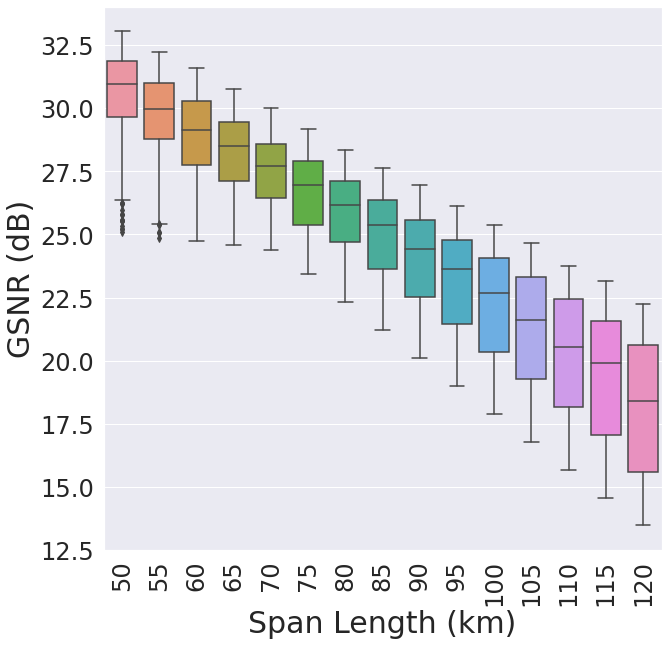

In [ ]:
for i in data.columns:
  if str(i) == 'Lspan(km)':
    plt.figure()
    fig,ax = plt.subplots(figsize=(10,10))
    b = sns.boxplot(x = str(i), y = 'GSNR-Span(dB)',  data = data,ax=ax)
    #plt.title(str(i)+' vs GSNRSpan(dB)')
    ticks = plt.setp(ax.get_xticklabels(),rotation=90, size = 24)
    b.set_yticklabels(b.get_yticks(), size = 24)
    plt.xlabel('Span Length (km)', fontsize=30)
    plt.ylabel('GSNR (dB)', fontsize=30) 
    #sns.set(font_scale = 1)
    plt.show()

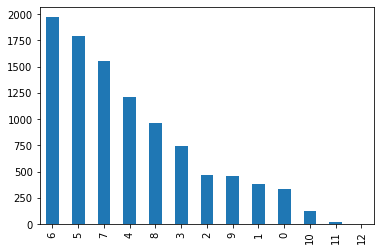

In [ ]:
data['RHEffecIdle'].value_counts().plot(kind='bar')

* 12 categories of districts

* Most districts are located less than 2, while the smallest part is 12

### Outlier detection

In [ ]:
for column in data.columns:
    if data[column].dtype == np.float64:
        plt.figure(figsize = (20, 3))
        ax = sns.boxplot(x = data[column])

## Clean Dataset

### Outleirs

In [ ]:
def remove_outleirs(dataframe, column_name, threshold):
    outliers_index = (dataframe[column_name] > threshold).values.nonzero()
    
    return dataframe.drop(labels = outliers_index[0], axis = 0)

In [ ]:
clean_data = remove_outleirs(data, column_name = "RHCongLSP(%)", threshold = 38)

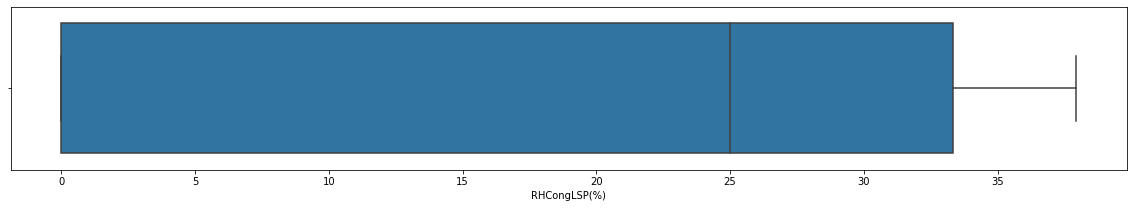

In [ ]:
plt.figure(figsize = (20, 3))
ax = sns.boxplot(x = clean_data["RHCongLSP(%)"])

### Redundancy data

In [ ]:
def remove_duplicates(dataframe):
    duplicated_indexes = dataframe.duplicated(keep = "first")
    return dataframe[~duplicated_indexes]

In [ ]:
clean_data = remove_duplicates(clean_data)

In [ ]:
print("duplicated =>", clean_data.duplicated(keep = "first").sum())

duplicated => 0


### Inconsistency data

In [ ]:
def remove_inconsistencies(dataframe, columns):
    inconsistent_indexes = dataframe.duplicated(subset = columns, keep = False)
    return dataframe[~inconsistent_indexes]

In [ ]:
features_columns = list(clean_data.columns)
features_columns.remove('SnrLink(dB)')

In [ ]:
print("Inconsistency =>", clean_data.duplicated(subset = features_columns, keep = False).sum())

Inconsistency => 0


In [ ]:
indexes = clean_data.duplicated(subset = features_columns, keep = False).values.nonzero()
clean_data.iloc[indexes]

,Rs(GBu),NumCh,BCh(GHz),Lspan(KM),Ptx(dBm),CutNumCh,ChDistCutCen,TotCongLSP(%),RHEffecIdle,LHEffecIdle,RHCongLSP(%),RFirstIdle,LHCongLSP(%),LFirstIdle,PowNli(dB),PowAse(dB),SnrLink(dB)


In [ ]:
X = clean_data.drop("SnrLink(dB)", axis=1)
y = clean_data["SnrLink(dB)"].copy()

## Data Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Missing data

In [ ]:
data_filler = SimpleImputer(strategy="median")
numerical_data = X_train
data_filler.fit(numerical_data)
np.set_printoptions(suppress=True)
print(data_filler.statistics_)

[      64.          59.    64000000.          85.           0.
       45.          21.          51.111        1.           7.
       25.           0.          53.488        0.         -69.144
      -55.195]


## Pipeline

In [ ]:
numerical_columns = list(numerical_data)
categorical_columns = ["RHEffecIdle"]

In [ ]:
numerical_pipeline = Pipeline([
        ('data_filler', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

X_train_numerical = numerical_pipeline.fit_transform(numerical_data)

In [ ]:
pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

## Models

In [ ]:
def rmse_r2(model,y,y_predict):    
    rmse = (np.sqrt(mean_squared_error(y, y_predict)))
    r2 = r2_score(y, y_predict)
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

In [ ]:
def score_rmse_r2(model,X,y):    
    rmse = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error').mean()
    r2 = cross_val_score(model, X, y, cv=10, scoring='r2').mean()
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

In [ ]:
def get_predict(model,X_train,y_train,X_test,y_test):
    print("\nThe model performance for training set")
    print("--------------------------------------")
    y_predict = model.predict(X_train)
    rmse_r2(model,y_train,y_predict)
    print("\nThe model performance for testing set")
    print("--------------------------------------")
    y_predict = model.predict(X_test)
    rmse_r2(model,y_test,y_predict)
    diff = y_test - y_predict
    diff.hist(bins = 40)
    plt.grid()
    
    plt.title('Histogram of prediction errors')
    plt.xlabel('MPG prediction error')
    plt.ylabel('Frequency')

In [ ]:
def get_score_predict(model,X_train,y_train,X_test,y_test):
    print("\nThe model performance for training set")
    print("--------------------------------------")
    score_rmse_r2(model,X_train,y_train)
    print("\nThe model performance for validation set")
    print("--------------------------------------")
    score_rmse_r2(model,X_test,y_test)

In [ ]:
def test_score(model,X,y):
    print("\nThe model performance for testing set")
    print("--------------------------------------")
    score_rmse_r2(model,X,y)

In [ ]:
def get_model_grid_search(model, parameters, X, y, pipeline):
    
    X = pipeline.fit_transform(X)    
    
    random_search = RandomizedSearchCV(model,
                            param_distributions=parameters,
                            scoring='r2',
                            verbose=1, n_jobs=-1,
                            n_iter=1000)
    
    grid_result = random_search.fit(X, y)
    
    print('Best R2: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)  
    
    return random_search.best_estimator_

In [ ]:
def get_model_random_search(model, parameters, X, y, pipeline):
    
    X = pipeline.fit_transform(X)    
    clf = GridSearchCV(model, parameters, scoring='r2',cv=10,verbose=1, n_jobs=-1)
    grid_result = clf.fit(X, y)
    
    print('Best R2: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)  
    
    return clf.best_estimator_

In [ ]:
def k_fold_score(model, X ,y):
    kf = KFold(n_splits = 10)
    rmse_list = []
    r2_list = []
    for train_index, test_index in kf.split(X, y):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]

        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)

        rmse = (np.sqrt(mean_squared_error(y_test, y_predict)))
        r2 = r2_score(y_test, y_predict)
        rmse_list.append(rmse)
        r2_list.append(r2)


    rmse_list = np.array(rmse_list)
    r2_list = np.array(r2_list)

    print("--------------------------------------")
    print('RMSE is {}'.format(rmse_list.mean()))
    print('R2 score is {}'.format(r2_list.mean()))

In [ ]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
data_gs, data_cv, target_gs, target_cv = train_test_split(X, y, test_size=0.95, random_state=42)

### LinearRegression

### Cross Validation


The model performance for training set
--------------------------------------
RMSE is 1.6300141824777457
R2 score is 0.8909121574533414

The model performance for testing set
--------------------------------------
RMSE is 1.7343179716332549
R2 score is 0.8885740249681386


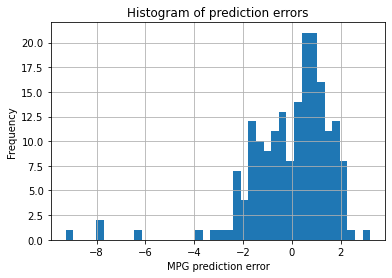

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
get_predict(lin_model,X_train,y_train,X_test,y_test)

### Grid Search

**Elastic-Net Regression**

Elastic-net is a linear regression model that combines the penalties of Lasso and Ridge.

In [ ]:
params = {
    'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],       
    'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

en = ElasticNet()

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

en_model = get_model_grid_search(en, params, data_gs, target_gs, pipeline)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 77 is smaller than n_iter=1000. Running 77 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best R2:  0.8103450587652894
Best Params:  {'l1_ratio': 0, 'alpha': 0.1}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.294e+01, tolerance: 1.193e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### K Fold

In [ ]:
k_fold_score(en_model,data_cv, target_cv)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+03, tolerance: 1.952e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e+03, tolerance: 1.965e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

--------------------------------------
RMSE is 1.6820361184426722
R2 score is 0.8800621687627869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+03, tolerance: 2.011e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+03, tolerance: 1.957e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

### Random Search

Random search differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. The major benefit being decreased processing time.
There is a tradeoff to decreased processing time, however. We aren’t guaranteed to find the optimal combination of hyperparameters.

Let’s give random search a try with sklearn’s RandomizedSearchCV. Very similar to grid search above, we define the hyperparameters to search over before running the search.

An important additional parameter to specify here is n_iter. This specifies the number of combinations to randomly try.

Selecting too low of a number will decrease our chance of finding the best combination. Selecting too large of a number will increase our processing time.


In [ ]:
params = {
    'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],       
    'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

en = ElasticNet()

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

en_rs_model = get_model_random_search(en, params, data_gs, target_gs, pipeline)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best R2:  0.8103450587652894
Best Params:  {'alpha': 0.1, 'l1_ratio': 0}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.294e+01, tolerance: 1.193e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
k_fold_score(en_rs_model, data_cv, target_cv)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+03, tolerance: 1.952e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e+03, tolerance: 1.965e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

--------------------------------------
RMSE is 1.6820361184426722
R2 score is 0.8800621687627869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+03, tolerance: 2.011e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+03, tolerance: 1.957e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

## Support Vector Machine Regressor

### Cross validation


The model performance for training set
--------------------------------------
RMSE is 0.3994536076650545
R2 score is 0.9870842543787731

The model performance for testing set
--------------------------------------
RMSE is 0.5054774099762858
R2 score is 0.9768274617530865


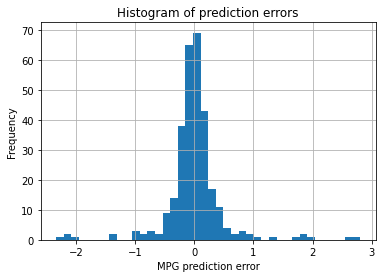

In [ ]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
get_predict(svr,X_train,y_train,X_test,y_test)

### Grid Search

In [ ]:
params = {  'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }

svr = SVR(kernel='rbf')

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

svr_model = get_model_grid_search(svr, params, data_gs, target_gs, pipeline)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 308 is smaller than n_iter=1000. Running 308 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 308 candidates, totalling 1540 fits
Best R2:  0.9635470041244929
Best Params:  {'gamma': 0.005, 'epsilon': 0.0001, 'C': 100}


### K Fold

In [ ]:
k_fold_score(svr_model,data_cv, target_cv)

--------------------------------------
RMSE is 0.2833178897952145
R2 score is 0.9931263208236734


### Random Search

In [ ]:
params = {  'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }

svr = SVR(kernel='rbf')

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

svr_rs_model = get_model_random_search(svr, params, data_gs, target_gs, pipeline)

Fitting 5 folds for each of 308 candidates, totalling 1540 fits
Best R2:  0.9635470041244929
Best Params:  {'C': 100, 'epsilon': 0.0001, 'gamma': 0.005}


In [ ]:
k_fold_score(svr_rs_model, data_cv, target_cv)

--------------------------------------
RMSE is 0.2833178897952145
R2 score is 0.9931263208236734


## Decision Tree Regressor

### Cross Validation


The model performance for training set
--------------------------------------
RMSE is 0.0
R2 score is 1.0

The model performance for testing set
--------------------------------------
RMSE is 0.1998573660824357
R2 score is 0.9963774830713796


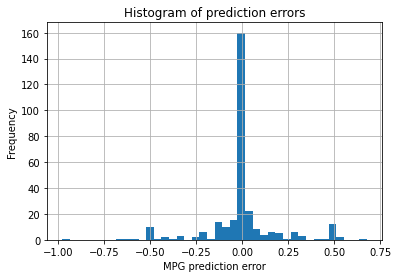

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
get_predict(tree, X_train, y_train, X_test, y_test)

### Grid Search

In [ ]:
params = {'min_samples_split': range(2, 10)}

tree = DecisionTreeRegressor()

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

tree_model = get_model_grid_search(tree, params, data_gs, target_gs, pipeline)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best R2:  0.7736274767090187
Best Params:  {'min_samples_split': 3}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=1000. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


### K Fold

In [ ]:
k_fold_score(tree_model, data_cv, target_cv)

--------------------------------------
RMSE is 0.21481016466848385
R2 score is 0.9960099722963622


### Random Search

In [ ]:
params = {'min_samples_split': range(2, 10)}

tree = DecisionTreeRegressor()

pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_columns),
    ])

tree_rs_model = get_model_random_search(tree, params, data_gs, target_gs, pipeline)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best R2:  0.7303574467776628
Best Params:  {'min_samples_split': 9}


In [ ]:
k_fold_score(tree_rs_model, data_cv, target_cv)

--------------------------------------
RMSE is 0.22589848480496508
R2 score is 0.9956278232851037
